In [1]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import rosbag
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d
from IPython.display import display
#from mpldatacursor import datacursor
import time
import math
import cv2 as cv2
from cv_bridge import CvBridge
import argparse
import os
from IPython import display

In [2]:
#READ BAG

fileroot='2021-01-11-UTS/'
filename='2021-01-11-UTS-P1'

saverpath='/media/maleen/malen_ssd/phd/cloud_academic/ams_data/datasets/'
#bag  = rosbag.Bag('/home/maleen/rosbags/'+fileroot+ filename + '.bag')

bag  = rosbag.Bag('/media/maleen/malen_ssd/phd/critical_ams_data/'+fileroot+ filename + '.bag')

In [3]:
encsize=0
odomsize=0
rtkllasize=0
rtkenusize=0
imusize=0
yolosize=0
lasersize=0
rtabsize=0
rgbsize=0
depthsize=0

encoder_time=np.array([])
encoder_seq=np.array([])
encoder_x=np.array([])
encoder_y=np.array([])

odom_time=np.array([])
odom_seq=np.array([])
odom_x=np.array([])
odom_y=np.array([])
odom_theta=np.array([])

odom_vx=np.array([])
odom_vy=np.array([])
odom_vtheta=np.array([])

rtklla_time=np.array([])
rtklla_seq=np.array([])
rtklla_lat=np.array([])
rtklla_long=np.array([])
rtklla_alti=np.array([])

rtkenu_time=np.array([])
rtkenu_seq=np.array([])
rtkenu_x=np.array([])
rtkenu_y=np.array([])
rtkenu_z=np.array([])

imu_time=np.array([])
imu_seq=np.array([])
imu_angvZ=np.array([])
imu_angvX=np.array([])
imu_angvY=np.array([])

yolo_time=np.array([])
yolo_seq=np.array([])
image_time=np.array([])
image_seq=np.array([])
image_frame=np.array([])
bounding_box=[]
detectimg_time=np.array([])
detectimg=np.array([])
foundobj=np.array([])
foundobj_time=np.array([])

laser_time=np.array([])
laser_seq=np.array([])
laser_range=np.array([])

rtab_time=np.array([])
rtab_seq=np.array([])
rtab_x=np.array([])
rtab_y=np.array([])
rtab_theta=np.array([])

rtab_orientx=np.array([])
rtab_orienty=np.array([])
rtab_orientz=np.array([])
rtab_orientw=np.array([])
            
encoder_data=np.array([])


back_rgb_time=np.array([])
back_rgb_img=np.array([])
back_rgb_seq=np.array([])

back_depth_time=np.array([])
back_depth_seq=np.array([])
back_depth_img=np.array([])

vel_ned_time=np.array([])
vel_ned_seq=np.array([])
vel_n=np.array([])
vel_e=np.array([])
vel_d=np.array([])




#topiclist=['/encoder_ticks','/piksi/navsatfix_best_fix','/back_cam/aligned_depth_to_color/image_raw','/back_cam/color/image_raw','/rtabmap/localization_pose']
topiclist=['/encoder_ticks','/back_cam/aligned_depth_to_color/image_raw','/back_cam/color/image_raw']
#,'/back_cam/aligned_depth_to_color/image_raw''/piksi/vel_ned',

for topic, msg, t in bag.read_messages(topics=topiclist): #
    
        if topic=='/encoder_ticks':
            
            encoder_time=np.append(encoder_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            encoder_seq=np.append(encoder_seq,msg.header.seq)
            encoder_x=np.append(encoder_x,msg.ticks.x)
            encoder_y=np.append(encoder_y,msg.ticks.y)
            encsize=encsize+1           
            
        elif topic=='/back_cam/color/image_raw':
            
            
            back_rgb_time=np.append(back_rgb_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            back_rgb_seq=np.append(back_rgb_seq,msg.header.seq)
            back_rgb_img=np.append(back_rgb_img,msg)
            rgbsize=rgbsize+1

        elif topic=='/back_cam/aligned_depth_to_color/image_raw':
           
            back_depth_time=np.append(back_depth_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            back_depth_seq=np.append(back_depth_seq,msg.header.seq)
            #back_depth_img=np.append(back_depth_img,msg)
print(encoder_time[0])      

1610354651.436696707


In [4]:
back_depth_time

array([Decimal('1610354651.478180467'), Decimal('1610354651.546352635'),
       Decimal('1610354651.620698519'), ...,
       Decimal('1610355456.818602997'), Decimal('1610355456.8874902'),
       Decimal('1610355456.955016059')], dtype=object)

In [5]:
#BRING DATA TO ENCODER TIME

back_rgb_time=back_rgb_time-encoder_time[0]
back_depth_time=back_depth_time-encoder_time[0]

encoder_time=encoder_time-encoder_time[0]

In [6]:
#PROCESS ENCODER DATA

encoder_wraps_x=0
encoder_wraps_y=0


encoder_x_new=np.copy(encoder_x)
encoder_y_new=np.copy(encoder_y)

for x in range(1,encoder_x.size-1):
    
    diff=encoder_x[x]-encoder_x[x-1]

 # check wrap around
    if abs(diff) > 16770000:
            # if positive wrap around, increase
        if abs(encoder_x[x]) < abs(encoder_x[x-1]):
                #print("Positive")
            encoder_wraps_x = encoder_wraps_x + 1
        # else decrease
        else:
            #print("Negative")
            encoder_wraps_x = encoder_wraps_x - 1

    encoder_x_new[x] = (16777216*encoder_wraps_x) + encoder_x[x]
           
        
for x in range(1,encoder_y.size-1):
    
    
    diff = encoder_y[x] - encoder_y[x-1]
        #print("current y : ", encoder_y[x], "previous y :", encoder_y[x-1], "diff : ", diff)

        # check wrap around
    if abs(diff) > 16770000:
            #if positive wrap around, increase
        if abs(encoder_y[x] < abs(encoder_y[x-1])):
                #print("Positive")
            encoder_wraps_y = encoder_wraps_y + 1
            # else decrease
        else:
                #print("Negative")
            encoder_wraps_y = encoder_wraps_y - 1

    encoder_y_new[x] = (16777216*encoder_wraps_y) + encoder_y[x]
        #print("tmpY : ", tmpY)

encoder_mean=(-encoder_x_new+encoder_y_new)/2
#encoder_x=encoder_x

encoderdata={'encoder_seq':encoder_seq, 'encoder_time':encoder_time, 'encoder_x_new':-encoder_x_new, 'encoder_y_new':encoder_y_new, 'encoder_mean':encoder_mean}
encoder_df = pd.DataFrame(encoderdata, columns=['encoder_seq','encoder_time','encoder_x_new','encoder_y_new','encoder_mean'])
#print encoder_df



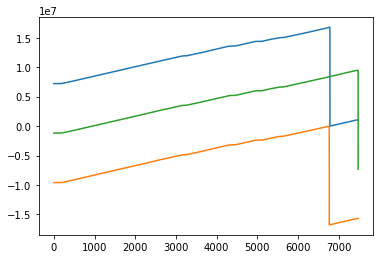

In [7]:
plt.plot(encoder_y)
plt.plot(-encoder_x)
plt.plot(encoder_mean)

In [8]:
odomdata_enc={'odom_seq':odom_seq, 'odom_time':odom_time, 'odom_x':odom_x, 'odom_y':odom_y, 'odom_theta':odom_theta, 'odom_vx':odom_vx,'odom_vy':odom_vy,'odom_vtheta':odom_vtheta}
odom_df_enc= pd.DataFrame(odomdata_enc, columns=['odom_seq','odom_time','odom_x','odom_y','odom_theta','odom_vx','odom_vy','odom_vtheta'])

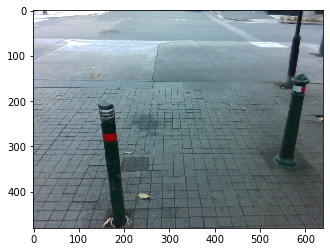

11835


In [ ]:
bridge = CvBridge()
back_images=[]


for num in range(0,rgbsize):

    cv_image = bridge.imgmsg_to_cv2(back_rgb_img[num], desired_encoding="passthrough")
    back_images.append(cv_image)
    

plt.imshow(back_images[20])
#plt.imshow(detected_images[25])
plt.show()

i=1
print(num)
for num in range(0,rgbsize):
    
    cv2.imwrite('/media/maleen/malen_ssd/phd/critical_ams_data/'+fileroot+'image_data/'+filename+'/ground-rgb/'+ filename +"-"+ str(num+1) + ".jpg",cv2.cvtColor(back_images[num],cv2.COLOR_BGR2RGB)) #[int(cv2.IMWRITE_JPEG_QUALITY), 100]) 


    #cv2.imwrite('/home/ravindra/HDD-4TB/Maleen/image_data/ground-rgb/'+ filename + "-"+ str(i) + ".jpg",cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #[int(cv2.IMWRITE_JPEG_QUALITY), 100]) 
    



    


In [11]:
back_rgb_data={'back_rgb_seq':back_rgb_seq, 'back_rgb_time':back_rgb_time}
back_rgb_df = pd.DataFrame(back_rgb_data,columns=['back_rgb_seq','back_rgb_time'])

back_rgb_df.to_csv(saverpath+fileroot+'csv_data/'+filename + '-back_rgb.csv')

In [12]:
back_depth_data={'back_depth_seq':back_depth_seq, 'back_depth_time':back_depth_time}
back_depth_df = pd.DataFrame(back_depth_data,columns=['back_depth_seq','back_depth_time'])

back_depth_df.to_csv(saverpath+fileroot+'csv_data/'+filename + '-back_depth.csv')


In [13]:
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

In [14]:
# load our serialized edge detector from disk
print("[INFO] loading edge detector...")
protoPath ="hed_model/deploy.prototxt"
modelPath = "hed_model/hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# register our new layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

[INFO] loading edge detector...


In [15]:
i=1

back_rgb_time.size
%matplotlib inline

for num in range(0,rgbsize):
    
    img=back_images[num]
    
    (H, W) = img.shape[:2]
    
    # construct a blob out of the input image for the Holistically-Nested
    # Edge Detector

    blob = cv2.dnn.blobFromImage(img, scalefactor=1, size=(W, H),
        mean=(104.00698793, 116.66876762, 122.67891434),
        swapRB=False, crop=False)
    
    #mean=(104.00698793, 116.66876762, 122.67891434),
    
    net.setInput(blob)
    hed = net.forward()
    hed = cv2.resize(hed[0, 0], (W, H))
    hed = (255 * hed).astype("uint8")
    
    ret1,thresh1 = cv2.threshold(hed,160,255,cv2.THRESH_BINARY)

    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # remove noise
    #img = cv2.GaussianBlur(gray,(5,5),0)

    # convolute with proper kernels
    #laplacian = cv2.Laplacian(img,cv2.CV_64F)
    #sobelx = cv2.Sobel(hed,cv2.CV_64F,1,0,ksize=3)  # x
    #sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y

    #plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
    #plt.title('Original'), plt.xticks([]), plt.yticks([])
    #plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
    #plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
    #plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
    #plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
    #plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
    #plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

    #plt.show()
    
    
    #kernel1 = np.ones((2,2),np.uint8)
    
    #kernel2 = np.ones((2,2),np.uint8)
    
    #erosion = cv2.erode(hed, kernel1,iterations=3)
    #dilate = cv2.dilate(erosion, kernel2,iterations=2)
    
    
    
    #convert = cv2.convertScaleAbs(opening)
    #blurred = cv2.GaussianBlur(convert, (5, 5), 0)
    
    #canny = cv2.Canny(blurred, 100, 200)
    
#     fig=plt.imshow(thresh1)
#     plt.show(fig)
    

    cv2.imwrite('/media/maleen/malen_ssd/phd/critical_ams_data/'+fileroot+'image_data/'+filename+'/edge/'+ filename +"-edge"+"-"+ str(num+1) + ".jpg",thresh1) #[int(cv2.IMWRITE_JPEG_QUALITY), 100]) 

print(num)

13678


In [16]:
rgbsize

13679

In [ ]:
# ret1,thresh1 = cv2.threshold(hed,160,255,cv2.THRESH_BINARY)

In [ ]:
# plt.imshow(thresh1,'gray')
# plt.show()
# cv2.imwrite('/home/maleen/test.jpg',thresh1)

In [ ]:
# for num in range(0,5):
#     print(num) 

In [ ]:
# print('/media/maleen/malen_ssd/phd/ICRA2021_data/'+fileroot+'image_data/'+filename+'/edge/')

\